In [120]:
import pandas as pd
import openpyxl
import os
import re
import timeit
import numpy as np
import json
import pytz
import zipfile
from datetime import datetime

## constants

In [121]:
MAX_FILES_TO_PROCESS = 99

RELEASE = "2024_ISP_final"

INPUT_FOLDER = "./input"
OUTPUT_FOLDER = "./output"

CACHE_FOLDER = "cache"
OUTLOOKS_FOLDER = "outlooks"

TIME_ZONE = pytz.timezone("Australia/Sydney")


## fueltech mappings

In [122]:
FUELTECH_MAPPINGS = {
    "Brown Coal": "coal_brown",
    "Black Coal": "coal_black",
    "Solar Thermal": "solar_thermal",
    "Utility-scale Solar": "solar_utility",
    "Imports": "imports",
    "Exports": "exports",
    "Distributed PV": "solar_rooftop",
    "Wind": "wind",
    "Hydro": "hydro",
    "Distributed Storage": "battery_distributed_discharging",
    "Distributed Storage Load": "battery_distributed_charging",
    "Mid-merit Gas": "gas_ccgt",
    "Mid-merit Gas with CCS": "gas_ccgt_ccs",
    "Offshore Wind": "wind_offshore",
    "Peaking Gas\+Liquids": "gas_ocgt",
    "Hydrogen Turbine": "gas_hydrogen",
    "Utility-scale Storage": "battery_discharging",
    "Utility-scale Storage Load": "battery_charging",
    "Offshore wind": "wind_offshore",
    "Coordinated DER Storage": "battery_VPP_discharging",
    "Coordinated DER Storage Load": "battery_VPP_charging",
    "DSP": "demand_response",

    # 2024 draft
    "Flexible Gas": "gas_ocgt",
    "Passive CER Storage": "battery_distributed_discharging",
    "Passive CER Storage Load": "battery_distributed_charging",
    "Coordinated CER Storage": "battery_VPP_discharging",
    "Coordinated CER Storage Load": "battery_VPP_charging",
    "Biomass": "bioenergy_biomass",

    # 2024 final
    "Brown coal": "coal_brown",
    "Black coal": "coal_black",
    "Mid-merit gas": "gas_ccgt",
    "Flexible gas with CCS": "gas_ccgt_ccs",
    "Flexible gas": "gas_ocgt",

    "Utility storage": "battery_discharging",
    "Utility storage load": "battery_charging",
    "Coordinated CER storage": "battery_VPP_discharging",
    "Coordinated CER storage load": "battery_VPP_charging",
    "Passive CER storage": "battery_distributed_discharging",
    "Passive CER storage load": "battery_distributed_charging",

    "Utility solar": "solar_utility",
    "Other renewable fuels": "bioenergy",
}

# Reverse the FUEL_TECH_MAPPINGS dictionary
FUELTECH_TO_DESCRIPTION = {v: k for k, v in FUELTECH_MAPPINGS.items()}

def get_fuelTechDescription(fuel_tech_id):
    # Use the reversed dictionary to get the readable string
    return FUELTECH_TO_DESCRIPTION.get(fuel_tech_id, fuel_tech_id)

FUELTECH_COLORS = {
    'battery_charging': '#4F5FD7',
    'battery_discharging': '#3145CE',
    'battery_VPP_charging': '#4F5FD7',
    'battery_VPP_discharging': '#3145CE',
    'battery_distributed_charging': '#4F5FD7',
    'battery_distributed_discharging': '#3145CE',
    'battery': '#3145CE',

    'bioenergy': '#069FAF',
    'bioenergy_biogas': '#069FAF',
    'bioenergy_biomass': '#0B757C',

    'coal': '#251C00',
    'coal_black': '#251C00',
    'coal_brown': '#675B42',

    'distillate': '#E46E56',

    'gas': '#E78114',
    'gas_ccgt': '#ED9C2C',
    'gas_ccgt_ccs': '#F1AB4B',
    'gas_ocgt': '#F0AC4A',
    'gas_recip': '#F4C379',
    'gas_steam': '#E78114',
    'gas_wcmg': '#DA630E',
    'gas_hydrogen': '#C75338',

    'hydro': '#ACE9FE',
    'pumps': '#00A5F1',

    'solar': '#FECE00',
    'solar_utility': '#FECE00',
    'solar_thermal': '#FDB200',
    'solar_rooftop': '#FFEB5C',

    'wind': '#246D36',
    'wind_offshore': '#53AD69',

    'nuclear': '#C75338',

    'imports': '#CFA7FF',
    'exports': '#722AF7',
    'interconnector': '#7F7F7F',
    'demand_response': '#7F7F7F',

    'fossil_fuels': '#594929',
    'renewables': '#52A972'
}

## utilities

In [133]:
def unhide_sheets(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".xlsx"):
            print("\nchecking", filename)
            workbook = openpyxl.load_workbook(os.path.join(directory, filename), keep_links=False)
            print("opened", filename)
    
            for sheet in workbook.sheetnames:
                print("checking", sheet)
                if workbook[sheet].sheet_state == 'hidden':
                    workbook[sheet].sheet_state = 'visible'
            workbook.save(filename)

# unhide_sheets("data")

def countEntriesByTechnology(data_frame, type):
    print("\nCount of type:", type)
    filtered_data_frame = data_frame[data_frame['Type'] == type]
    count_by_technology = filtered_data_frame.pivot_table(index='Technology', columns='CDP', values='Scenario', aggfunc='count', fill_value=0)
    print(count_by_technology)

def printDataSummary(data, startTime):
        countEntriesByTechnology(data, "energy")
        countEntriesByTechnology(data, "capacity")
        elapsed = timeit.default_timer() - startTime
        print(f"rows: {len(data)} processed in {elapsed:.1f} seconds")
  
def generate_id(row):
  if row['Region'] == 'nem':
    id = "au.nem."
  else:
    id = f"au.nem.{row['Region'].lower()}."

  if row['Technology'] != 'none':
      id += f"fuel_tech.{row['Technology']}."
  
  return id + f"{row['Type']}.{row['Scenario']}.{row['CDP'].lower()}"

## loading from outlooks workbook

### checks

In [124]:
def getYearsFromColumnNames(frame):
    year_columns = [col for col in frame.columns if col.isdigit() and len(col) == 4]
    years = sorted(int(col) for col in year_columns)
    return years

# check that all technology types in the dataframe are in alphabetical allowing underscrores
# fail hard if they're not
def checkTechnologyTypesAreMapped(combined):
    technology_types = combined['Technology'].unique()

    illegals = [tech for tech in technology_types if not tech.replace('_', '').isalpha()]
    if illegals:
        raise ValueError(f'ERROR: the following technology types are not mapped properly: {illegals}')
    print("INFO: all technology types appear to be mapped properly")


# get a list of all columns with a name that looks like a year, make sure there are at least 20 and they are sequential
def checkYearColumns(combined):
    years = getYearsFromColumnNames(combined)

    if len(years) <= 20 or not all(y2 == y1 + 1 for y1, y2 in zip(years, years[1:])):
        raise ValueError("ERROR: year columns should sequential and in format XXXX (eg. not XXXX-YY).")
    print(f"INFO: years are sequential: {years}")


def checkFuelTechValuesLegal(combined):
    # get the list of all columns that look like a year
    year_columns = [col for col in combined.columns if col.isdigit() and len(col) == 4]

    # copy only the rows where any year column has a value less than 0 or NaN
    failed_rows = combined[(combined[year_columns] < 0).any(axis=1) | combined[year_columns].isna().any(axis=1)]

    if not failed_rows.empty:
        # print the number of failed rows
        print(f"ERROR: {len(failed_rows)} of {len(combined)} rows have illegal values")
        print(failed_rows.head())

        # build a list of failed tech types
        failed_tech_types = failed_rows['Technology'].unique()
        raise ValueError(f"ERROR: the following technology types have illegal values: {failed_tech_types}")
    
    print("INFO: all technology types have valid values")

def runIntegrityChecks(combined):
    checkTechnologyTypesAreMapped(combined)
    checkYearColumns(combined)
    checkFuelTechValuesLegal(combined)

### fixes

In [125]:
def renameRegions(frame):
    frame['Region'] = frame['Region'].apply(lambda x: x if x == "nem" else x + "1")
    return frame
  
def renameTechnologyLabels(frame):  
    for old_label, new_label in FUELTECH_MAPPINGS.items():
        frame['Technology'] = frame['Technology'].replace(r'^{}$'.format(old_label), new_label, regex=True) 
    return frame

# rename financial year coluumns
# take a data frame, and for each column with a title in the form of '20xx-yy', rename it to '20yy'
def renameFinancialYearColumns(frame):
    print("INFO: renaming financial year columns…")
    count = 0

    for col in frame.columns:
        if re.match(r"^\d{4}-\d{2}$", col):
            new_col_name = "20" + col[5:]
            frame.rename(columns={col: new_col_name}, inplace=True)
            count += 1

    if count:
        print(f"INFO: renamed {count} financial years")


def makeSpecialTechsPositive(frame):
    print("INFO: flipping negative values")

    # get the list of all columns that look like a year
    year_columns = [col for col in frame.columns if col.isdigit() and len(col) == 4]

    flip_types = [
        "battery_charging",
        "battery_VPP_charging",
        "battery_distributed_charging",
        "exports",
    ]

    for tech_type in flip_types:
        # pull out the rows with column Technology = tech_type
        tech_rows = frame[frame["Technology"] == tech_type]
        
        # if any of the years are negative for the given tech_type
        num_negative = tech_rows[(tech_rows[year_columns] < 0).any(axis=1)].shape[0]
        
        if num_negative:
            # …make them positive
            print(f"INFO: {num_negative} rows with negative values found for '{tech_type}', making them positive")
            frame.loc[frame['Technology'] == tech_type, year_columns] = frame.loc[frame['Technology'] == tech_type, year_columns].abs()


def changeNumericColumnsToFloats(frame):
    # for all columns with a year header (format yyyy), chnage the type to a float
    for col in [col for col in frame.columns if re.match(r'\d{4}', col)]:
        frame[col] = frame[col].astype(float)


def multiplyBy1e6(frame):
    # for all columns with a year header (format yyyy), multiply by 1e6
    for col in [col for col in frame.columns if re.match(r'\d{4}', col)]:
        frame[col] = frame[col] * 1e6


def collapseSubregions(frame):
    # check whether the dataframe has a column called Subregion
    if 'Subregion' not in frame.columns:
        print("INFO: subregion column not found, no collapsing needed")
        return frame
    
    print("INFO: subregion column found, collapsing")
    before_rows = frame.shape[0]

    # make a new dataframe grouping by CDP, Region, Technology
    collapsed = frame.groupby(['CDP', 'Region', 'Technology']).sum().reset_index()

    # drop the Subregion column
    collapsed = collapsed.drop(columns=['Subregion'])

    after_rows = collapsed.shape[0]

    print(f"INFO: collapsing subregions went from {before_rows} to {after_rows} rows")
    return collapsed


# create a nem region, being the sum of all regions within each scenario, CDP, type and technology
def addNemRegion(df):
    nem_region = df.groupby(["Scenario", "CDP", "Type", "Technology"]).sum().reset_index()
    nem_region["Region"] = "nem"

    # exclude entries where Technology is 'imports' or 'exports'
    trim_nem = nem_region[~nem_region['Technology'].isin(['imports', 'exports'])]

    return pd.concat([df, trim_nem], ignore_index=True)

### test flip

In [126]:
# generate some demo data to feed into flipNegativeValues
def getDemoData():
    data = {
        'Technology': ['battery_charging', 'exports', 'solar_utility'],
        '2019': ["-10.5", "-20.5", "-30.4"],
        '2020': ["-5", "-15", "-25.1"],
        '2021': ["-7", "-17", "-27.5",]
    }
    return pd.DataFrame(data)

def testFlip():
    # Generate demo data
    demo = getDemoData()
    demo.info()
    print(demo)
    changeNumericColumnsToFloats(demo)
    demo.info()
    print(demo)
    makeSpecialTechsPositive(demo)
    print(demo)

# testFlip()

### loading and caching

In [127]:
def loadISPDataFromSheet(excel_file, sheetname):
    sheet = excel_file[sheetname]
    data = pd.DataFrame(sheet.values)
    
    # grab the column names from the 3rd row, using integers for the year headings
    data.columns = data.iloc[2].apply(lambda x: int(float(x)) if isinstance(x, float) else x)

    # remove blank rows
    data.drop([0, 1, 2], inplace=True)  
    data.dropna(how="all", inplace=True)

    return data


def getWorkbookData(label, workbook_path):
    excel_file = openpyxl.load_workbook(workbook_path)
  
    # grab generation, using it as the basic structure
    print("INFO: loading generation")
    generation = loadISPDataFromSheet(excel_file, 'Generation')

    # grab the flows
    print("INFO: loading imports and exports")
    flows = loadISPDataFromSheet(excel_file, 'Imports and Exports')
    
    if 'Flow' in flows.columns:  # ensure that 'Flow' column exists
        flows = flows[flows['Flow'].isin(['Imports', 'Exports'])]
        flows = flows.rename(columns={"Flow": "Technology"})
      
        # flip the sign of numbers in the row for exports
        flows.loc[flows['Technology'] == "Exports", generation.select_dtypes(include=[np.number]).columns] *= -1
    else:
        print("Column names of flows:", list(flows.columns))
        raise ValueError("ERROR: the Flows column is missing")
      
    # grab the capacities 
    print("INFO: loading capacity")
    capacities = loadISPDataFromSheet(excel_file, 'Capacity')

    # grab the emissions
    print("INFO: loading emissions")
    emissions = loadISPDataFromSheet(excel_file, 'Emissions')
    emissions = emissions.drop(columns=['Total'])       # remove the Total column
    emissions['Technology'] = "none"                    # set the Technology column to "none" 
    
    # remove the column 'Existing and Committed' and remove "_discharging" from any tech labels
    # capacities = capacities.drop(columns=['Existing and Committed'])

    # 2024 draft
    # TODO only drop for 2024 draft?
    #capacities = capacities.drop(2024, axis=1)

    # 2024 final: remove '2023-24' from capacities
    # TODO only drop for 2024
    capacities = capacities.drop(columns=['2023-24'])

    # some workbooks have year columns in format 2023-24, others in 2024, so rename them all to 2024
    dataframes = [capacities, generation, flows, emissions]
    for frame in dataframes:
        renameFinancialYearColumns(frame)
        changeNumericColumnsToFloats(frame)
        renameRegions(frame)

    # introduced for 2024 final: remove 'Subregion' column if it exists
    capacities = collapseSubregions(capacities)
    generation = collapseSubregions(generation)

    # check the dataframes are compatible 
    if set(generation.columns) != set(flows.columns) or set(generation.columns) != set(capacities.columns) or set(generation.columns) != set(emissions.columns):
        print("generation columns:", list(generation.columns))
        print("flows columns:", list(flows.columns))
        print("capacities columns:", list(capacities.columns))
        print("emissions columns:", list(emissions.columns))
        raise ValueError("ERROR: The column names of generation, flows, capacities and emissions are not identical.")

    # touch up the energyies
    energies = pd.concat([generation, flows], ignore_index=True)
    energies.insert(0, "Type", "energy")
    energies = renameTechnologyLabels(energies)
    makeSpecialTechsPositive(energies)                   # flip the sign of negative values
  
    # touch up the capacities
    capacities.insert(1, "Type", "capacity")
    capacities = renameTechnologyLabels(capacities)
    capacities['Technology'] = capacities['Technology'].apply(lambda x: x[:-12] if x.endswith("_discharging") else x)  # remove _discharging from tech labels
    
    # touch up the emissions
    emissions.insert(1, "Type", "emissions")
    multiplyBy1e6(emissions)

    # now combine them and add a column with the file label (in snake case)
    combined = pd.concat([energies, capacities, emissions], ignore_index=True)
    combined.insert(0, "Scenario", re.sub(r'\W+', '_', label.strip().lower()))

    combined = addNemRegion(combined)
  
    return combined


def processGenerationOutlookFiles(release_name):
    process_start_time = timeit.default_timer()
    combined_data = pd.DataFrame()

    # fail hard if the ISP index file does not exist
    index_file = os.path.join(INPUT_FOLDER, release_name, "scenarios.json")
    if not os.path.exists(index_file):
        raise ValueError(f"ERROR: the scenario index file '{index_file}' does not exist.")
    
    # load the list of ISP files from the JSON file
    with open(index_file) as f:
        scenario_files = json.load(f)    

    # fail hard if there is no list of ISP files
    if len(scenario_files) == 0:
        raise ValueError(f"ERROR: the scenarios list from '{index_file}' is empty.")

    num_files_processed = 0
    for file_info in scenario_files:
        if num_files_processed >= MAX_FILES_TO_PROCESS:
            break

        file_name = file_info['file_name'] 
        workbook_path = os.path.join(INPUT_FOLDER, release_name, file_name)
        print(f"\nloading release '{release_name}', scenario '{file_info['label']}' from '{workbook_path}'")
      
        file_start_time = timeit.default_timer()
        outlook_data = getWorkbookData(file_info["label"], workbook_path)
        printDataSummary(outlook_data, file_start_time)
        
        combined_data = pd.concat([combined_data, outlook_data], ignore_index=True)
        num_files_processed += 1

    # print final summary and write CSV file
    print("\n\naggregated data")
    printDataSummary(combined_data, process_start_time)

    return combined_data


# read from cache if it exists, otherwise process and write to cache
def loadGenerationOutlooks(release_name):
    # compute the cache director name and ensure that it exists
    cache_path = os.path.join(OUTPUT_FOLDER, CACHE_FOLDER)
    if not os.path.exists(cache_path):
        print("creating cache directory")
        os.makedirs(cache_path)

    FILENAME_PARQUET = os.path.join(cache_path, release_name + ".outlook.parquet")

    if not os.path.exists(FILENAME_PARQUET):
        print(f"\nINFO: processing ISP outlook workbooks for release '{release_name}'")
        combined_data = processGenerationOutlookFiles(release_name)

        # output as a CSV file in the cache folder
        FILENAME_CSV = os.path.join(cache_path, release_name + ".outlook.csv")
        combined_data.to_csv(FILENAME_CSV)

        runIntegrityChecks(combined_data)

        # if all is good, write to the cache
        print(f"\nwriting to cache '{FILENAME_PARQUET}'")
        combined_data.round(1).to_parquet(FILENAME_PARQUET) # TODO not sure about this round(1) call here!
    else:
        print(f"WARNING: loading from cache file '{FILENAME_PARQUET}'")
        combined_data = pd.read_parquet(FILENAME_PARQUET)
        runIntegrityChecks(combined_data)
    
    return combined_data


outlooks = loadGenerationOutlooks(RELEASE)
outlooks.info()

creating cache directory

INFO: processing ISP outlook workbooks for release '2024_ISP_final'

loading release '2024_ISP_final', scenario 'Step Change' from './input/2024_ISP_final/2024 ISP - Step Change - Core.xlsx'
INFO: loading generation
INFO: loading imports and exports
INFO: loading capacity
INFO: loading emissions
INFO: renaming financial year columns…
INFO: renamed 28 financial years
INFO: renaming financial year columns…
INFO: renamed 28 financial years
INFO: renaming financial year columns…
INFO: renamed 28 financial years
INFO: renaming financial year columns…
INFO: renamed 28 financial years
INFO: subregion column found, collapsing
INFO: collapsing subregions went from 4290 to 1768 rows
INFO: subregion column found, collapsing
INFO: collapsing subregions went from 5226 to 2158 rows
INFO: flipping negative values
INFO: 130 rows with negative values found for 'battery_charging', making them positive
INFO: 130 rows with negative values found for 'battery_VPP_charging', making 

## build a simple chart

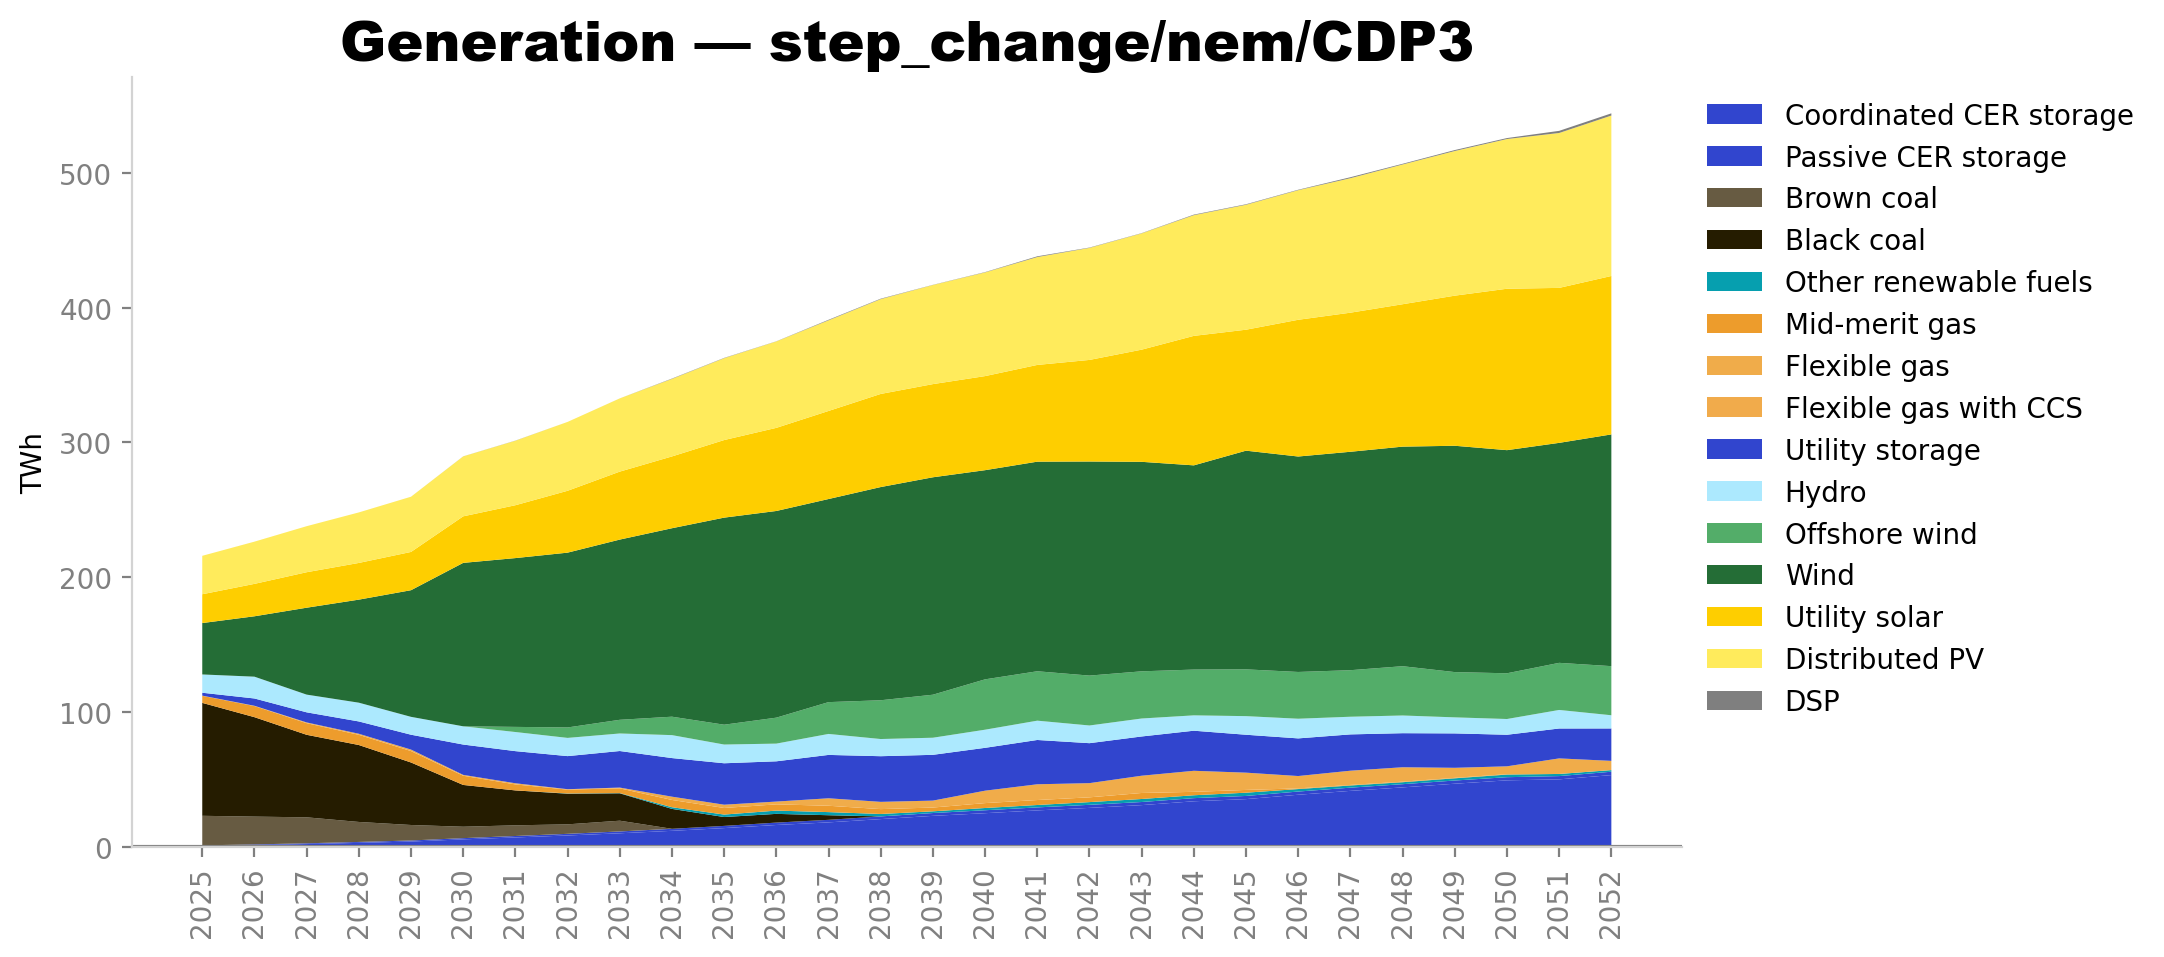

In [128]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'  # For high-resolution displays

def reorder_columns(data):
    FUELTECH_ORDER = [
        'battery_charging',
        'battery_VPP_discharging',
        'battery_distributed_discharging',
        'pumps',
        'exports',
        'coal_brown',
        'coal_black',
        'bioenergy',
        'bioenergy_biogas',
        'bioenergy_biomass',
        'distillate',
        'gas_steam',
        'gas_ccgt',
        'gas_ocgt',
        'gas_recip',
        'gas_wcmg',
        'gas_ccgt_ccs',
        'gas_ocgt_ccs',
        'gas_hydrogen',
        'battery_discharging',
        'hydro',
        'wind_offshore',
        'wind',
        'solar_thermal',
        'solar_utility',
        'solar_rooftop',
        'demand_response'
    ]

    # battery_VPP_discharging
    # battery_distributed_discharging
    # demand_response
    # gas_ccgt_ccs
    # gas_hydrogen
    # solar_thermal
    # wind_offshore

    # Get the intersection of the order and the columns in the data
    common_columns = [col for col in FUELTECH_ORDER if col in data.columns]

    # Check if there are any columns in the data that are not in the order
    extra_columns = [col for col in data.columns if col not in FUELTECH_ORDER]
    if extra_columns:
        print(f"WARN: data contains the following fuel techs not found in FUEL_TECH_ORDER: {', '.join(extra_columns)}")

    # Reorder the columns in data
    reordered_data = data[common_columns]
    return reordered_data


def create_area_chart(outlooks, scenario, type, CDP, region):
    # Filter the data based on the provided parameters
    filtered_data = outlooks[(outlooks['Scenario'] == scenario) & (outlooks['Type'] == type) & (outlooks['CDP'] == CDP) & (outlooks['Region'] == region)]

    # Reshape the data so that each year is a separate row
    reshaped_data = filtered_data.melt(id_vars=['Scenario', 'Type', 'CDP', 'Region', 'Technology'], var_name='Year', value_name='Value')

    # Pivot the data so that each technology is a separate column
    pivoted_data = reshaped_data.pivot(index='Year', columns='Technology', values='Value')

    # Remove columns ending with '_charging'
    pivoted_data = pivoted_data[pivoted_data.columns.drop(list(pivoted_data.filter(regex='_charging')))]

    # Divide all values in the DataFrame by 1000
    pivoted_data = pivoted_data.divide(1000)

    # Reorder the columns in pivoted_data
    pivoted_data = reorder_columns(pivoted_data)

    # Create a new figure with a specific size
    plt.figure(figsize=(10, 5))

    # Create a list of colors for the columns in pivoted_data
    colors = [FUELTECH_COLORS.get(fueltech_id, '#000000') for fueltech_id in pivoted_data.columns]

    # Plot the stacked area chart
    plt.stackplot(pivoted_data.index, pivoted_data.T, colors=colors)

    # Rotate x-axis labels 90 degrees
    plt.xticks(rotation=90)

    plt.ylabel('TWh')
    plt.title(f'Generation — {scenario}/{region}/{CDP}', fontname='Arial Black', fontsize=20)

    # Map the column names to their display names
    display_names = [get_fuelTechDescription(fueltech_id) for fueltech_id in pivoted_data.columns]

    # Move the legend to the right of the chart
    plt.legend(display_names, bbox_to_anchor=(1.00, 1), loc='upper left', frameon=False)

    # Remove the right and top spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_color('lightgrey')    
    plt.gca().spines['bottom'].set_color('lightgrey')
    
    # Add x-axis and y-axis in light grey
    plt.axhline(0, color='grey')

    # Make all axes and tick marks in light grey
    plt.tick_params(colors='grey')

    plt.show()

create_area_chart(outlooks, 'step_change', 'energy', 'CDP3', 'nem')


# TESTING

### testing collapsing subregions

In [129]:
# show all the entries for CDP=CDP1 in Region=NSW1 and Technology=coal_black
def printCDP1_NSW1_Coal(frame):
    print(frame[(frame['CDP'] == 'CDP1') & (frame['Region'] == 'NSW1') & (frame['Technology'] == 'coal_black')])


def myGenTest():
    # load the generation parquet file
    energies = pd.read_parquet("generation.parquet")
    renameTechnologyLabels(energies)
    renameRegions(energies)
    makeSpecialTechsPositive(energies)

    print("\n\n>>> before:")
    printCDP1_NSW1_Coal(energies)

    # make a new dataframe with all columns except the Subregion column, grouping by CDP, Region, Technology
    new_energies = collapseSubregions(energies)

    print("\n\n>>> after:")
    printCDP1_NSW1_Coal(new_energies)

    new_energies.info()
    print(new_energies.head())

    return new_energies

# my_gen = myGenTest()
# my_gen

### testing emissions

## output to JSON

In [134]:
# put all the elements of the numerical array on the same line
def compact_json(json_str):
    # This regex looks for the _numerical_ data array and captures everything in between [ and ]
    pattern = r'("data": \[)([\d\., \n]*)(\])'
    
    # The inner function is used to replace newlines and spaces between array items
    def replacer(match):
        start, middle, end = match.groups()
        # Replace newline and possible spaces
        compact_middle = middle.replace('\n', '').replace(' ', '').replace(',', ', ')
        return start + compact_middle + end
    
    return re.sub(pattern, replacer, json_str, flags=re.DOTALL)

def build_json(release, outlooks, type, region):
    data = []

    if type == "energy":
        units = "GWh"
    elif type == "capacity":
        units = "MW"
    elif type == "emissions":
        units = "tCO2e"
    else:
        raise ValueError(f"ERROR: unknown type '{type}'")

    # extract start and end year
    years = getYearsFromColumnNames(outlooks)
    start_year = years[0] - 1   # subtract 1 to account for start of financial year
    last_year = years[-1] - 1
    start = f"{start_year}-07-01T00:00:00+10:00"
    last = f"{last_year}-07-01T00:00:00+10:00"
   
    for i, row in outlooks.iterrows():
        if row['Region'] == region and row['Type'] == type:
            # change numbers to just 1 decimal place
            year_data = [round(x, 1) for x in row[pd.to_numeric(row.index, errors='coerce')>=2022].tolist()]  # selecting only year data
            # year_data = row[pd.to_numeric(row.index, errors='coerce')>=2022].tolist()  # selecting only year data
              
            element = {
                "id": generate_id(row),
                "type": type,
                "network": "nem",
                "region": region,
                "fuel_tech": row['Technology'],
                "scenario": row['Scenario'],
                "pathway": row['CDP'],
                "units": units,
                "projection": {
                    "start": start,
                    "last": last,
                    "interval": "1Y",
                    "data": year_data
                }
            }

            # remove the region attribute if we're outputting the nem region
            if region == 'nem':
                del element["region"]
              
            data.append(element)

    output_obj = {
        "type": type,
        "version": "4.0",
        "network": "nem",
        "region": region,
        "release": release,
        "created_at": datetime.now(TIME_ZONE).strftime("%Y-%m-%dT%H:%M:%S%z"),
        "messages": [ f"projections from AEMO's {release} generation outlooks" ],
        "data": data,
    }

    # remove the region attribute if we're outputting the nem region
    if region == 'nem':
        del output_obj["region"]

    json_output = json.dumps(output_obj, indent=2)
    return compact_json(json_output)      

In [135]:
def generatePath(release, type, region):  
  if region == 'nem':
    path = os.path.join(OUTPUT_FOLDER, OUTLOOKS_FOLDER, release, "au", "NEM", type, "outlook.json")
  else:
    path = os.path.join(OUTPUT_FOLDER, OUTLOOKS_FOLDER, release, "au", "NEM", region, type, "outlook.json")
  return path

def writeJSON(release, outlooks, type, region):
  json = build_json(release, outlooks, type, region)
  file_path = generatePath(release, type, region)
  os.makedirs(os.path.dirname(file_path), exist_ok=True)
  with open(file_path, 'w') as json_file:
    json_file.write(json)

def writeJSONS(release, outlooks):
  num_files = 0
  for type in outlooks['Type'].unique():
    for region in outlooks['Region'].unique():
      print(f"writing {generatePath(release, type, region)}")
      writeJSON(release, outlooks, type, region)
      num_files += 1
      
  print(f"wrote {num_files} JSON files")
  
def zipdir(path, zip_path):
    zipf = zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED)
    for root, dirs, files in os.walk(path):
      for file in files:
        zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(path, '..')))
    zipf.close()


outlooks = loadGenerationOutlooks(RELEASE)
printDataSummary(outlooks, timeit.default_timer())
writeJSONS(RELEASE, outlooks)

# zipdir('outlooks', 'outlooks.zip')

INFO: all technology types appear to be mapped properly
INFO: years are sequential: [2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052]
INFO: all technology types have valid values

Count of type: energy
CDP                              CDP1  CDP10  CDP11  CDP12  CDP13  CDP14  \
Technology                                                                 
battery_VPP_charging               18     18     18     18     18     18   
battery_VPP_discharging            18     18     18     18     18     18   
battery_charging                   18     18     18     18     18     18   
battery_discharging                18     18     18     18     18     18   
battery_distributed_charging       18     18     18     18     18     18   
battery_distributed_discharging    18     18     18     18     18     18   
bioenergy                          18     18     18     18     18     1

## new output format

In [136]:
outlooks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Scenario    15600 non-null  object 
 1   Type        15600 non-null  object 
 2   CDP         15600 non-null  object 
 3   Region      15600 non-null  object 
 4   Technology  15600 non-null  object 
 5   2025        15600 non-null  float64
 6   2026        15600 non-null  float64
 7   2027        15600 non-null  float64
 8   2028        15600 non-null  float64
 9   2029        15600 non-null  float64
 10  2030        15600 non-null  float64
 11  2031        15600 non-null  float64
 12  2032        15600 non-null  float64
 13  2033        15600 non-null  float64
 14  2034        15600 non-null  float64
 15  2035        15600 non-null  float64
 16  2036        15600 non-null  float64
 17  2037        15600 non-null  float64
 18  2038        15600 non-null  float64
 19  2039        15600 non-nul

In [144]:
RELEASES_FOLDER = "releases"

def getUnitFromType(series_type):
    if series_type == "energy":
        return "GWh"
    elif series_type == "capacity":
        return "MW"
    elif series_type == "emissions":
        return "tCO2e"
    else:
        raise ValueError(f"ERROR: unknown type '{series_type}'")

def buildNewJSON(outlooks, release, scenario):
    data = []

    # extract start and end year
    years = getYearsFromColumnNames(outlooks)
    start_year = years[0] - 1   # subtract 1 to account for start of financial year
    last_year = years[-1] - 1
    start = f"{start_year}-07-01T00:00:00+10:00"
    last = f"{last_year}-07-01T00:00:00+10:00"
   
    for i, row in outlooks.iterrows():
        if row['Scenario'] == scenario:
            # change numbers to just 1 decimal place
            year_data = [round(x, 1) for x in row[pd.to_numeric(row.index, errors='coerce')>=2022].tolist()]  # selecting only year data
              
            element = {
                "id": generate_id(row),
                "type": row['Type'],
                "network": "nem",
                "region": row['Region'],
                "fuel_tech": row['Technology'],
                "scenario": row['Scenario'],
                "pathway": row['CDP'],
                "units": getUnitFromType(row['Type']),
                "projection": {
                    "start": start,
                    "last": last,
                    "interval": "1Y",
                    "data": year_data
                }
            }

            # remove the region attribute if we're outputting the nem region
            # if region == 'nem':
            #     del element["region"]
              
            data.append(element)

    output_obj = {
        "version": "4.1",
        "network": "nem",
        "release": release,
        "created_at": datetime.now(TIME_ZONE).strftime("%Y-%m-%dT%H:%M:%S%z"),
        "messages": [ f"projections from AEMO's {release} generation outlooks" ],
        "data": data,
    }

    json_output = json.dumps(output_obj, indent=2)
    return compact_json(json_output)


def writeNewJSON(root, outlooks, release, scenario):
    print(f"INFO: writing {release}/{scenario}")

    json_output = buildNewJSON(outlooks, release, scenario)
    filename = f"{scenario}.json"
    path = os.path.join(root, filename)
    with open(path, "w") as f:
        f.write(json_output)


def writeNewJSONs(release):
    outlooks = loadGenerationOutlooks(release)

    # make the enclosing folder
    root = os.path.join(OUTPUT_FOLDER, RELEASES_FOLDER, release)
    print(f"INFO: creating folder {root}")
    os.makedirs(root, exist_ok=True)

    for scenario in outlooks['Scenario'].unique():
        writeNewJSON(root, outlooks, release, scenario)

writeNewJSONs(RELEASE)

INFO: all technology types appear to be mapped properly
INFO: years are sequential: [2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052]
INFO: all technology types have valid values
INFO: creating folder ./output/releases/2024_ISP_final
INFO: writing 2024_ISP_final/step_change


TypeError: Object of type type is not JSON serializable